In [26]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import cv2
import joblib
from skimage.feature import hog

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize



In [2]:
# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change this path to where your folder is located in Drive
base_path = '/content/drive/MyDrive/driver_distraction/'
csv_path = os.path.join(base_path, 'driver_imgs_list.csv')
img_dir = os.path.join(base_path,'train')

# Read CSV file
labels_df = pd.read_csv(csv_path)
print('CSV Loaded. Shape:', labels_df.shape)
print(labels_df.head())

CSV Loaded. Shape: (22424, 3)
  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


To read all the raw driver distraction images, convert them into a uniform format suitable for machine learning, and store them efficiently for further processing (feature extraction, PCA, etc.).

In [4]:
# --- Load & preprocess images with checkpointing (Colab-ready) ---
# Parameters
IMG_SIZE = (128, 128)
GRAYSCALE = True
CHECKPOINT_INTERVAL = 1000  # save every N images
SAVE_DIR = '/content/drive/MyDrive/driver_distraction'

# Paths
x_partial_path = os.path.join(SAVE_DIR, 'X_train_partial.npy')
y_partial_path = os.path.join(SAVE_DIR, 'y_train_partial.npy')

# --- Resume from checkpoint if exists ---
X, y = [], []
if os.path.exists(x_partial_path) and os.path.exists(y_partial_path):
    X = list(np.load(x_partial_path, allow_pickle=True))
    y = list(np.load(y_partial_path, allow_pickle=True))
    print(f"Resuming from {len(X)} previously saved images...")
else:
    print("Starting fresh...")

start_index = len(X)

# --- Load images using CSV mapping ---
for idx, row in tqdm(
    labels_df.iloc[start_index:].iterrows(),
    total=len(labels_df) - start_index,
    desc='Loading train images'
):
    class_label = row['classname'] if 'classname' in row else row['class']
    img_name = row['img']
    img_path = os.path.join(img_dir, class_label, img_name)

    img = cv2.imread(img_path)
    if img is None:
        continue

    if GRAYSCALE:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

    X.append(img)
    y.append(class_label)

    # --- Checkpoint save every N images ---
    if (idx + 1) % CHECKPOINT_INTERVAL == 0:
        np.save(x_partial_path, np.array(X, dtype=object))
        np.save(y_partial_path, np.array(y, dtype=object))
        print(f"Checkpoint saved at {idx + 1} images...")

# --- Convert to numpy arrays ---
X = np.array(X)
y = np.array(y)

# --- Final save ---
np.save(os.path.join(SAVE_DIR, 'X_train.npy'), X)
np.save(os.path.join(SAVE_DIR, 'y_train.npy'), y)

# Clean up partials
if os.path.exists(x_partial_path):
    os.remove(x_partial_path)
if os.path.exists(y_partial_path):
    os.remove(y_partial_path)

print(f"\n Loaded {X.shape[0]} images. Image shape: {X.shape[1:]}. Unique classes: {np.unique(y)}")
print(" Saved final arrays: X_train.npy and y_train.npy")


Starting fresh...


Loading train images:   4%|▍         | 1008/22424 [00:15<20:52, 17.09it/s]

Checkpoint saved at 1000 images...


Loading train images:   9%|▉         | 1996/22424 [00:30<05:02, 67.45it/s]

Checkpoint saved at 2000 images...


Loading train images:  13%|█▎        | 2996/22424 [00:49<04:46, 67.86it/s]

Checkpoint saved at 3000 images...


Loading train images:  18%|█▊        | 4011/22424 [01:18<44:43,  6.86it/s]  

Checkpoint saved at 4000 images...


Loading train images:  22%|██▏       | 5008/22424 [01:46<2:07:22,  2.28it/s]

Checkpoint saved at 5000 images...


Loading train images:  27%|██▋       | 6005/22424 [02:11<1:26:35,  3.16it/s]

Checkpoint saved at 6000 images...


Loading train images:  31%|███▏      | 7012/22424 [02:38<1:08:54,  3.73it/s]

Checkpoint saved at 7000 images...


Loading train images:  36%|███▌      | 8012/22424 [03:07<1:09:50,  3.44it/s]

Checkpoint saved at 8000 images...


Loading train images:  40%|████      | 9009/22424 [03:36<1:05:00,  3.44it/s]

Checkpoint saved at 9000 images...


Loading train images:  45%|████▍     | 10007/22424 [04:07<1:15:04,  2.76it/s]

Checkpoint saved at 10000 images...


Loading train images:  49%|████▉     | 11007/22424 [04:42<1:27:34,  2.17it/s]

Checkpoint saved at 11000 images...


Loading train images:  54%|█████▎    | 12010/22424 [05:17<1:19:19,  2.19it/s]

Checkpoint saved at 12000 images...


Loading train images:  58%|█████▊    | 13006/22424 [05:53<1:19:32,  1.97it/s]

Checkpoint saved at 13000 images...


Loading train images:  62%|██████▏   | 14009/22424 [06:35<1:28:51,  1.58it/s]

Checkpoint saved at 14000 images...


Loading train images:  67%|██████▋   | 15007/22424 [07:19<1:28:53,  1.39it/s]

Checkpoint saved at 15000 images...


Loading train images:  71%|███████▏  | 16008/22424 [08:03<1:19:31,  1.34it/s]

Checkpoint saved at 16000 images...


Loading train images:  76%|███████▌  | 17007/22424 [08:46<53:37,  1.68it/s]  

Checkpoint saved at 17000 images...


Loading train images:  80%|████████  | 18007/22424 [09:34<56:50,  1.30it/s]  

Checkpoint saved at 18000 images...


Loading train images:  85%|████████▍ | 19000/22424 [10:24<1:29:18,  1.57s/it]

Checkpoint saved at 19000 images...


Loading train images:  89%|████████▉ | 20008/22424 [11:11<33:14,  1.21it/s]

Checkpoint saved at 20000 images...


Loading train images:  94%|█████████▎| 21006/22424 [12:29<1:00:10,  2.55s/it]

Checkpoint saved at 21000 images...


Loading train images:  98%|█████████▊| 22000/22424 [18:03<1:05:57,  9.33s/it]

Checkpoint saved at 22000 images...


Loading train images: 100%|██████████| 22424/22424 [23:34<00:00, 15.86it/s]



 Loaded 22424 images. Image shape: (128, 128). Unique classes: ['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']
 Saved final arrays: X_train.npy and y_train.npy


The 10 classes to predict are:

c0: safe driving

c1: texting - right

c2: talking on the phone - right

c3: texting - left

c4: talking on the phone - left

c5: operating the radio

c6: drinking

c7: reaching behind

c8: hair and makeup

c9: talking to passenger

**What we are doing here**

->Images in the dataset might have different sizes; resizing makes them uniform so features (like HOG) are comparable across samples.

->HOG (Histogram of Oriented Gradients) works on edge orientations, not color, so grayscale reduces data complexity and noise.

->  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY):Reduces image to a single channel (edges + textures only), making further feature extraction faster and more effective.

->X.append(img) and y.append(class_label):Builds your dataset in memory for ML use — X holds image data, y holds labels.

->Conversion of raw images into reusable NumPy arrays, so you don’t need to reload and resize 22k images again — you can directly load them later with np.load().



---



---



To convert every image into a numerical feature vector that represents the shape, structure, and edges — which are key for detecting driver behavior (like using phone, looking away, etc.).

**What HOG Does**

HOG stands for Histogram of Oriented Gradients.
Instead of storing raw pixel intensities (which are hard for ML models to interpret), HOG focuses on how edges are oriented in small regions of the image.
Well-suited for classic ML models (SVM, KNN, Decision Trees).

It captures:

->The direction of edges (e.g., vertical, horizontal, diagonal)

->The magnitude (how strong the edge is)

->The spatial distribution of these edges across the image

These patterns help identify gestures, body posture, and hand positions — which are exactly what “driver distraction” recognition needs.

In [9]:
# Optimized HOG Feature Extraction with Parallel Processing and Autosave

#  Load the preprocessed images and labels
X = np.load('/content/drive/MyDrive/driver_distraction/X_train.npy', allow_pickle=True)
y = np.load('/content/drive/MyDrive/driver_distraction/y_train.npy', allow_pickle=True)

print(f"Loaded data: {X.shape}, Labels: {y.shape}")

# HOG Parameters (for 128x128 grayscale images)
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True
}

# Helper function to extract HOG from one image
def extract_hog(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return hog(img, **hog_params)

#  Parallel Extraction using all available CPU cores
print("Extracting HOG features in parallel — this may take a few minutes...")
hog_features = Parallel(n_jobs=-1, backend='loky')(
    delayed(extract_hog)(img) for img in tqdm(X, desc="Extracting HOG (parallel)")
)

X_hog = np.array(hog_features)
print(f"\n HOG feature matrix shape: {X_hog.shape}")

# --- Save the feature matrix and labels ---
np.save('/content/drive/MyDrive/driver_distraction/X_hog.npy', X_hog)
np.save('/content/drive/MyDrive/driver_distraction/y_hog.npy', y)
print("Saved: X_hog.npy and y_hog.npy to Google Drive")


Loaded data: (22424, 128, 128), Labels: (22424,)
Extracting HOG features in parallel — this may take a few minutes...


Extracting HOG (parallel): 100%|██████████| 22424/22424 [03:14<00:00, 115.17it/s]



 HOG feature matrix shape: (22424, 8100)
Saved: X_hog.npy and y_hog.npy to Google Drive


**What we are doing here:**


*   Divide the image into small cells(8x8 pixels):Breaks image into smaller, manageable parts.
*   Compute gradients in X and Y directions:Finds where and how strongly intensity changes occur (i.e., edges).


*   Build histograms of gradient directions:Represents how edges are oriented in each region

*   Normalize across blocks of cells:Ensures lighting changes or shadows don’t affect the feature values.
*  Flatten all histograms(Combine into a single long vector):Produces a single feature vector representing the image’s structure.







---



---



To reduce the 8,100-dimensional HOG features into a smaller number of dimensions (say 100–200) without losing much information, and to visualize how the images are distributed in this lower-dimensional space.

**What PCA Does**

Principal Component Analysis (PCA) finds new axes (directions) in your data along which:

->The variance (information) is maximum,

->The components are uncorrelated (no redundancy).

->Removes noise and redundancy in HOG vectors.

->Less Overfitting:Keeps only the most informative patterns.

In simple words — it takes all your correlated HOG features and compresses them into fewer, more powerful “summary features.” ie models train faster on 100 features than 8100.

HOG feature matrix shape: (22424, 8100)
Features normalized.
PCA complete. Reduced shape: (22424, 1488)
Saved: PCA transformer and Scaler as .pkl files


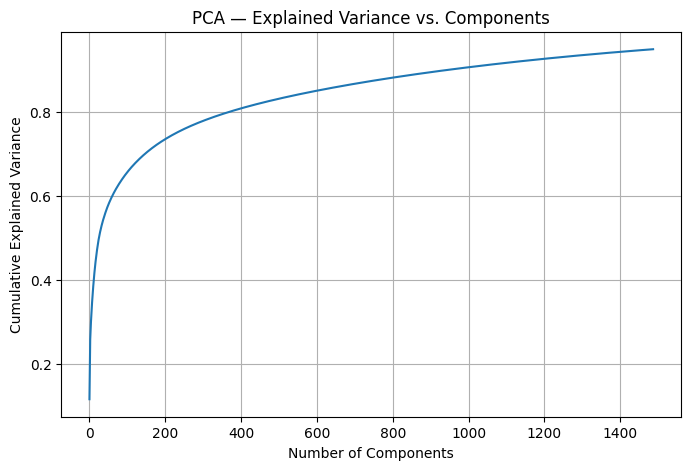

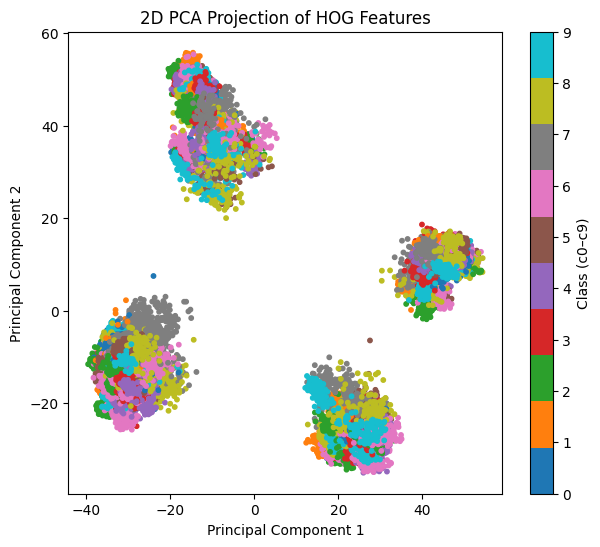

Saved: X_pca.npy and y_pca.npy 


In [10]:
# Normalize features and apply PCA (with visualization)

# Load HOG feature matrix and labels
X_hog = np.load('/content/drive/MyDrive/driver_distraction/X_hog.npy')
y = np.load('/content/drive/MyDrive/driver_distraction/y_hog.npy')
print(f"HOG feature matrix shape: {X_hog.shape}")

#Normalize the features
scaler = StandardScaler() #Scale all features to have mean = 0 and variance = 1
X_scaled = scaler.fit_transform(X_hog)
print("Features normalized.")

#  Apply PCA
# Keep enough components to explain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled) #Transform data into this new, lower-dimensional space.
print(f"PCA complete. Reduced shape: {X_pca.shape}")

#Save PCA and Scaler objects for future prediction
joblib.dump(pca, '/content/drive/MyDrive/driver_distraction/pca_transformer.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/driver_distraction/scaler.pkl')
print("Saved: PCA transformer and Scaler as .pkl files")

#Visualize explained variance
#Shows how many components you need to capture most of the data.
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA — Explained Variance vs. Components')
plt.grid(True)
plt.show()

#2D Visualization (first two principal components)
#Helps you see clustering — whether classes start to separate in reduced space.
plt.figure(figsize=(7,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=[int(label[1]) for label in y], cmap='tab10', s=10)
plt.title('2D PCA Projection of HOG Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Class (c0–c9)')
plt.show()

# Save PCA results
np.save('/content/drive/MyDrive/driver_distraction/X_pca.npy', X_pca)
np.save('/content/drive/MyDrive/driver_distraction/y_pca.npy', y)
print("Saved: X_pca.npy and y_pca.npy ")


**What we are doing here:**

*   Standardization:So all HOG features contribute equally — prevents large-magnitude features from dominating.
*   Covariance Matrix Calculation:Finds relationships between pixels’ gradient patterns.

*   Eigen Decomposition:Identifies the most informative patterns in the data.
*   Select Top Components:Keeps most of the useful information while reducing size dramatically.

* Project Data:Each image is now represented by fewer, stronger features.







**PCA variance vs components**

->At the start (0–200 components), the curve rises very steeply — this means the first few components capture most of the important information in your dataset.

->After that, the curve starts to flatten out — adding more components gives diminishing returns.

->The red dot near 1200 (if that’s your chosen point) may mark the number of components you selected to keep — likely because it captures enough variance (say 95%) without keeping all 1500.

**2D PCA projection of HOG**

->Principal Component 1 (x-axis) and Principal Component 2 (y-axis) are the two most informative directions in your data.

->You can see several distinct clusters of points — these clusters correspond to groups of images that look similar based on their HOG features.

->Some clusters contain mixed colors, meaning that different digit classes overlap — this suggests that some digits have similar gradient patterns (for example, “3” and “8” might look somewhat similar).



---



---



Loaded PCA data: (22424, 1488), Labels: (22424,)
Training on 4000 samples, testing on 1000 samples.

 Training SVM...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
SVM Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy: 0.9950


Training KNN...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
KNN Best Params: {'n_neighbors': 3}
KNN Accuracy: 0.9850

 
Training Decision Tree...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
 Decision Tree Best Params: {'criterion': 'entropy', 'max_depth': 10}
Decision Tree Accuracy: 0.6630

CLASSIFICATION REPORTS 

----------------------------------------------------------------------
SVM:
               precision    recall  f1-score   support

          c0       0.98      0.98      0.98       111
          c1       1.00      1.00      1.00       101
          c2       1.00      1.00      1.00       103
          c3       1.00      0.99      1.00       105
          c4       1.00      0.99      1.0

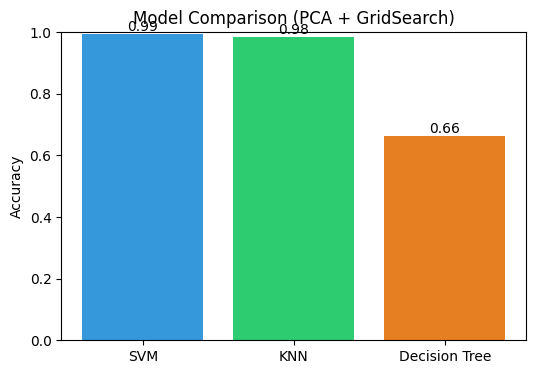

['/content/drive/MyDrive/driver_distraction/dt_model.pkl']

In [11]:
# Train and Compare Models (Optimized for Speed)

# Load PCA features and labels
X = np.load('/content/drive/MyDrive/driver_distraction/X_pca.npy')
y = np.load('/content/drive/MyDrive/driver_distraction/y_pca.npy')

print(f"Loaded PCA data: {X.shape}, Labels: {y.shape}")

# --- Sample down to 5k for faster GridSearch ---
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=5000, stratify=y, random_state=42)

#GridSearchCV is a hyperparameter tuning tool in scikit-learn.
#It helps you automatically find the best combination of parameters for a model.
'''
->It tries every possible combination of these parameter values.
->For each combination, it:
          -Trains the model
          -Evaluates it using cross-validation (that’s the cv argument)
          -Records the accuracy (or other scoring metric)

->After testing all combinations, it picks the one with the best performance.'''

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42)
print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples.")

# Support Vector Machine
#SVM (tuned for C, kernel, gamma)
print("\n Training SVM...")
svm_params = {'C':[1, 10], 'kernel':['linear', 'rbf'], 'gamma':['scale']}
svm = GridSearchCV(SVC(), svm_params, cv=2, n_jobs=-1, verbose=1)
svm.fit(X_train, y_train)
svm_best = svm.best_estimator_
svm_pred = svm_best.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print(f"SVM Best Params: {svm.best_params_}")
print(f"SVM Accuracy: {svm_acc:.4f}\n")

#  K-Nearest Neighbors
#KNN (tuned for n_neighbors)
print("\nTraining KNN...")
knn_params = {'n_neighbors':[3,5,7]}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=2, n_jobs=-1, verbose=1)
knn.fit(X_train, y_train)
knn_best = knn.best_estimator_
knn_pred = knn_best.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print(f"KNN Best Params: {knn.best_params_}")
print(f"KNN Accuracy: {knn_acc:.4f}\n")

# Decision Tree
#Decision Tree (tuned for max_depth, criterion)
print(" \nTraining Decision Tree...")
dt_params = {'max_depth':[5,10,20], 'criterion':['gini','entropy']}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=2, n_jobs=-1, verbose=1)
dt.fit(X_train, y_train)
dt_best = dt.best_estimator_
dt_pred = dt_best.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)
print(f" Decision Tree Best Params: {dt.best_params_}")
print(f"Decision Tree Accuracy: {dt_acc:.4f}\n")

# Compare Results  (precision, recall, F1-score)
print("CLASSIFICATION REPORTS \n")
print("-"*70)
print("SVM:\n", classification_report(y_test, svm_pred))
print("KNN:\n", classification_report(y_test, knn_pred))
print("Decision Tree:\n", classification_report(y_test, dt_pred))

#Plot comparison
models = ['SVM', 'KNN', 'Decision Tree']
accs = [svm_acc, knn_acc, dt_acc]
plt.figure(figsize=(6,4))
plt.bar(models, accs, color=['#3498db','#2ecc71','#e67e22'])
plt.ylabel('Accuracy')
plt.title('Model Comparison (PCA + GridSearch)')
plt.ylim(0,1)
for i, acc in enumerate(accs):
    plt.text(i, acc+0.01, f"{acc:.2f}", ha='center', fontsize=10)
plt.show()

joblib.dump(svm_best, '/content/drive/MyDrive/driver_distraction/svm_model.pkl')
joblib.dump(knn_best, '/content/drive/MyDrive/driver_distraction/knn_model.pkl')
joblib.dump(dt_best, '/content/drive/MyDrive/driver_distraction/dt_model.pkl')


**Model Performance Summary**

**SVM (RBF kernel): accuracy 0.995 (≈99.5%)**

Excellent performance — strong generalization and boundary modeling. The RBF kernel works great after PCA because it captures non-linear relationships in the reduced feature space.

**KNN (k=3): accuarcy 0.985 (≈98.5%)**

Also very high accuracy, meaning PCA preserved separability well. Slightly lower than SVM because KNN is more sensitive to overlapping class boundaries and data density.

**Decision Tree (max_depth=10, entropy): accuarcy 0.663 (≈66%)**

Much lower — typical for decision trees on high-dimensional continuous data like HOG/PCA. They tend to overfit and can’t model the subtle gradients as well as SVM/KNN.

*Key Inferences*
*   PCA worked well — compressing HOG features (from 8100 → 1488 dimensions) didn’t hurt accuracy; models still learned rich patterns.

*   SVM with RBF kernel worked the best — it handles complex boundaries and smooths noise better.
*  KNN is a strong baseline, simple but effective

*   Decision Trees struggle with continuous, non-linear data — they’d need ensemble techniques (Random Forests or XGBoost) to compete here.
*   Class balance seems perfect — precision/recall across all 10 classes (c0–c9) are near 1.00 for SVM/KNN, indicating no bias toward any class.








---



---



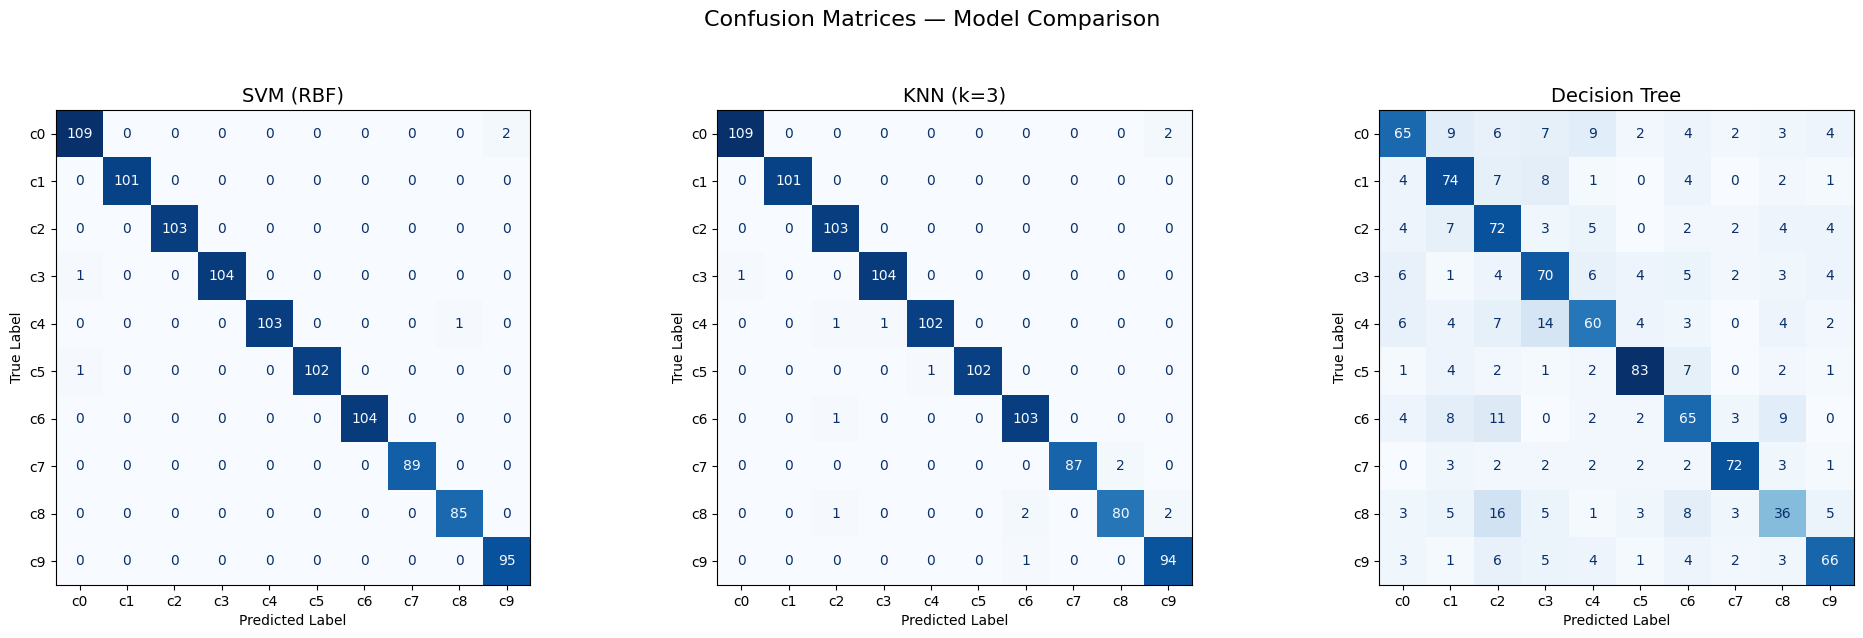

In [12]:
#CONFUSION MATRIX
#It will visually confirm what your classification report already shows
#— that your SVM (and possibly KNN) are classifying almost every class perfectly, with very few misclassifications.

# Predict for each model
y_pred_svm = svm_best.predict(X_test)
y_pred_knn = knn_best.predict(X_test)
y_pred_dt  = dt_best.predict(X_test)

# Compute confusion matrices
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y_test))
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=np.unique(y_test))
cm_dt  = confusion_matrix(y_test, y_pred_dt,  labels=np.unique(y_test))

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, cm, title in zip(
    axes,
    [cm_svm, cm_knn, cm_dt],
    ['SVM (RBF)', 'KNN (k=3)', 'Decision Tree']
):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.suptitle('Confusion Matrices — Model Comparison', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


1. SVM (RBF)

Almost perfect diagonal matrix → most predictions are correct.

Very few misclassifications (tiny off-diagonal numbers).

Best performing model — highly accurate and consistent.

2. KNN (k=3)

Also very good — mostly diagonal.

A few small off-diagonal errors (e.g., c4 misclassified as c5).

Slightly less accurate than SVM, but still strong.

3. Decision Tree

Much more spread-out matrix → many off-diagonal values.

Indicates more confusion between classes.

Lowest accuracy — tends to overfit and generalize poorly on PCA-reduced data.



---



---



In [19]:
!pip install streamlit pyngrok joblib scikit-image opencv-python


In [21]:
from pyngrok import ngrok
!ngrok config add-authtoken 3418edUwWegRrbGu2viO68B4sTG_5G1GaYndrUDNkmoB8bms3

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [36]:
# Kill old tunnels if any
ngrok.kill()

# Open a new one for Streamlit (port 8501)
public_url = ngrok.connect(8501)
print(" Public URL:", public_url)


 Public URL: NgrokTunnel: "https://noninfinitely-unresemblant-monique.ngrok-free.dev" -> "http://localhost:8501"


In [33]:
%%writefile app.py
import streamlit as st
import cv2
import joblib
import numpy as np
from skimage.feature import hog

# === Load trained models & transformers ===
svm_model = joblib.load('/content/drive/MyDrive/driver_distraction/svm_model.pkl')
knn_model = joblib.load('/content/drive/MyDrive/driver_distraction/knn_model.pkl')
dt_model  = joblib.load('/content/drive/MyDrive/driver_distraction/dt_model.pkl')
scaler = joblib.load('/content/drive/MyDrive/driver_distraction/scaler.pkl')
pca_transformer = joblib.load('/content/drive/MyDrive/driver_distraction/pca_transformer.pkl')

# Streamlit UI
st.title("Driver Distraction Detection (SVM, KNN, Decision Tree)")
st.write("Enter a Google Drive image path (e.g., `/content/drive/MyDrive/driver_distraction/test_images/img_1.jpg`)")

# User input
img_path = st.text_input("Enter image path:", "")

if st.button("Predict"):
    if img_path.strip() == "":
        st.warning("Please enter a valid image path.")
    else:
        try:
            # Load and preprocess image
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (128, 128))

            # Extract HOG features
            hog_features = hog(img_resized, orientations=9, pixels_per_cell=(8,8),
                               cells_per_block=(2,2), block_norm='L2-Hys')

            # Scale & apply PCA
            hog_scaled = scaler.transform([hog_features])
            hog_pca = pca_transformer.transform(hog_scaled)

            # Predict using all 3 models
            svm_pred = svm_model.predict(hog_pca)[0]
            knn_pred = knn_model.predict(hog_pca)[0]
            dt_pred  = dt_model.predict(hog_pca)[0]

            # Display results
            st.image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), caption="Input Image", width=300)
            st.success("Predictions:")
            st.write(f"**SVM:** {svm_pred}")
            st.write(f"**KNN:** {knn_pred}")
            st.write(f"**Decision Tree:** {dt_pred}")

        except Exception as e:
            st.error(f"Error: {str(e)}")


Overwriting app.py


In [34]:
!streamlit run app.py &>/dev/null &






In [35]:
print("Your app is live here:", ngrok.get_tunnels()[0].public_url)



Your app is live here: https://noninfinitely-unresemblant-monique.ngrok-free.dev
